# Robust04: 3-Model Neural Retrieval Pipeline

**Gal Noy** · 209346486

**Dataset**: TREC Robust04 - 249 queries (50 train with qrels, 199 test), ~528K documents

**Pipeline**:
1. **Model 1 - BM25**: Baseline with k1, b tuning
2. **Model 2 - RM3**: Query expansion (fb_terms, fb_docs, original_weight)
3. **Model 3 - Neural**: Multi-branch (RM3+SPLADE) → RRF fusion → Neural PRF+MiniLM → Score blending

**Method**: Grid search for optimal parameters at each model using MAP on training queries

**Output**: Three TREC runs (run_1.res, run_2.res, run_3.res) for test queries

## 1. Setup & Dependencies

### 1.1. Install Required Packages

In [1]:
# !apt-get update
# !apt-get install -y openjdk-21-jdk
# !update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-21-openjdk-amd64/bin/java 1
# !update-alternatives --install /usr/bin/javac javac /usr/lib/jvm/java-21-openjdk-amd64/bin/javac 1
# !update-alternatives --set java /usr/lib/jvm/java-21-openjdk-amd64/bin/java
# !update-alternatives --set javac /usr/lib/jvm/java-21-openjdk-amd64/bin/javac

In [2]:
# !pip install matplotlib
# !pip install transformers
# !pip install sentence-transformers
# !pip install pytrec_eval
# !pip install torch torchvision torchaudio
# !pip install faiss-cpu --no-cache
# !pip install pyserini==0.36.0
# !pip install nltk

In [ ]:
import os
import re
import logging
import warnings
from abc import ABC, abstractmethod
from typing import Dict, List, Tuple, Optional, Iterable
from collections import defaultdict, Counter
from itertools import product
from functools import lru_cache

import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import tqdm
import pytrec_eval

import matplotlib.pyplot as plt
from IPython.display import display

from pyserini.search.lucene import LuceneSearcher, LuceneImpactSearcher
from pyserini.index.lucene import IndexReader
from pyserini.encode import SpladeQueryEncoder

from sentence_transformers import CrossEncoder

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()
logging.getLogger("transformers").setLevel(logging.ERROR)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Using device: {DEVICE}")
print("✓ Dependencies imported")

/home/galnoy/git-projects/MSC-Text-Retrieval-and-Search-Engines/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-17 10:30:24.467606034 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


Using device: cuda
✓ Dependencies imported


### 1.2. Load Pyserini Index

In [4]:
INDEX_NAME = "robust04"

index_reader = IndexReader.from_prebuilt_index(INDEX_NAME)

print(f"Index: {INDEX_NAME}")
print(f"Total documents: {index_reader.stats()['documents']:,}")
print(f"Total terms: {index_reader.stats()['total_terms']:,}")
print("✓ Pyserini index loaded")

Index: robust04
Total documents: 528,030
Total terms: 174,540,872
✓ Pyserini index loaded


Jan 17, 2026 10:30:25 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


## 2. Data Loading

---

**Note**: The 50 queries with qrels are used for training/tuning (parameter optimization via grid search). The remaining 199 queries without qrels are used for generating final submission files.

### 2.1. Load Queries

In [5]:
DATA_DIR = "./data/"

def load_queries(filepath: str) -> Dict[str, str]:
    """Load queries from file. Format: qid<tab>query_text"""
    queries = {}
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                qid, text = parts
                queries[qid] = text
    return queries

all_queries = load_queries(os.path.join(DATA_DIR, "queriesROBUST.txt"))

print(f"Total queries loaded: {len(all_queries)}")
print(f"\nSample queries:")
for qid, text in list(all_queries.items())[:5]:
    print(f"  {qid}: {text}")

Total queries loaded: 249

Sample queries:
  301: international organized crime
  302: poliomyelitis post polio
  303: hubble telescope achievements
  304: endangered species mammals
  305: dangerous vehicles


### 2.2. Load Relevance Judgments

In [6]:
def load_qrels(filepath: str) -> Dict[str, Dict[str, int]]:
    """Load qrels. Format: qid 0 docid relevance"""
    qrels = defaultdict(dict)
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                qid, _, docid, rel = parts[:4]
                qrels[qid][docid] = int(rel)
    return dict(qrels)

qrels = load_qrels(os.path.join(DATA_DIR, "qrels_50_Queries"))

print(f"Queries with relevance judgments: {len(qrels)}")
print(f"Total judgments: {sum(len(v) for v in qrels.values()):,}")
print(f"\nSample qrels for query 301:")
sample_rels = list(qrels.get("301", {}).items())[:5]
for docid, rel in sample_rels:
    print(f"  {docid}: {rel}")

Queries with relevance judgments: 50
Total judgments: 61,511

Sample qrels for query 301:
  FBIS3-10082: 1
  FBIS3-10169: 0
  FBIS3-10243: 1
  FBIS3-10319: 0
  FBIS3-10397: 1


### 2.3. Train/Test Split

In [7]:
train_qids = sorted(qrels.keys())
test_qids = [qid for qid in all_queries.keys() if qid not in train_qids]

train_queries = {qid: all_queries[qid] for qid in train_qids}
test_queries = {qid: all_queries[qid] for qid in test_qids}

print(f"Training queries: {len(train_queries)} (with qrels)")
print(f"Test queries: {len(test_queries)} (no qrels)")
print(f"\nTrain QIDs: {train_qids[:10]}...")
print(f"Test QIDs: {test_qids[:10]}...")

Training queries: 50 (with qrels)
Test queries: 199 (no qrels)

Train QIDs: ['301', '302', '303', '304', '305', '306', '307', '308', '309', '310']...
Test QIDs: ['351', '352', '353', '354', '355', '356', '357', '358', '359', '360']...


## 3. Evaluation Framework

---

**Evaluation Strategy**: All experiments use MAP (Mean Average Precision) computed with pytrec_eval. Grid search explores parameter combinations, caching results to avoid redundant computation. Best parameters from each model are carried forward to the next model.

### 3.1. Evaluation Functions

In [8]:
def compute_map(
    run: Dict[str, List[Tuple[str, float]]],
    qrels: Dict[str, Dict[str, int]]
) -> Tuple[float, Dict[str, float]]:
    """
    Compute MAP using pytrec_eval (TREC standard).

    Returns:
        map_score: float
        per_query_ap: Dict[qid, AP]
    """

    # Convert run to pytrec_eval format: {qid: {docid: score}}
    run_dict = {
        qid: {docid: score for docid, score in docs}
        for qid, docs in run.items()
    }

    # Convert qrels to pytrec_eval format: {qid: {docid: relevance}}
    qrels_dict = {
        qid: dict(docs)
        for qid, docs in qrels.items()
    }

    missing_qids = set(qrels_dict) - set(run_dict)
    assert not missing_qids, (
        f"Missing queries in run: {sorted(list(missing_qids))[:10]}"
    )

    for qid, docs in run.items():
        docids = [d for d, _ in docs]
        assert len(docids) == len(set(docids)), (
            f"Duplicate docIDs in run for query {qid}"
        )

    evaluator = pytrec_eval.RelevanceEvaluator(qrels_dict, {"map"})
    results = evaluator.evaluate(run_dict)

    per_query_ap = {qid: m["map"] for qid, m in results.items()}

    map_score = pytrec_eval.compute_aggregated_measure(
        "map",
        list(per_query_ap.values())
    )

    return map_score, per_query_ap


def evaluate_run(
    run: Dict[str, List[Tuple[str, float]]],
    qrels: Dict[str, Dict[str, int]],
    run_name: str = "run"
) -> Dict:
    """Evaluate a run using pytrec_eval and return metrics."""
    map_score, per_query_ap = compute_map(run, qrels)
    
    return {
        "run_name": run_name,
        "map": map_score,
        "num_queries": len(per_query_ap),
        "per_query_ap": per_query_ap
    }

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 3.2. Caching Utilities

In [9]:
def get_results_csv(model_num: int = None) -> str:
    """Get CSV filename for a specific model."""
    if model_num is None:
        return "./experiments.csv"
    return f"./experiments_model{model_num}.csv"


def generate_config_key(method: str, params: Dict) -> str:
    """Generate unique config key for caching."""
    parts = [method]
    for k, v in sorted(params.items()):
        parts.append(f"{k}={v}")
    return "__".join(parts)


def load_cached_result(config_key: str, model_num: int = None) -> Optional[Dict]:
    """Load cached result if exists."""
    results_csv = get_results_csv(model_num)
    
    if not os.path.exists(results_csv):
        return None
    
    df = pd.read_csv(results_csv)
    row = df[df["config_key"] == config_key]
    
    if row.empty:
        return None
    
    return row.iloc[0].to_dict()


def save_experiment_result(result: Dict, model_num: int = None):
    """Save experiment result to model-specific cache."""
    results_csv = get_results_csv(model_num)
    df_row = pd.DataFrame([result])
    
    if not os.path.exists(results_csv):
        df_row.to_csv(results_csv, index=False)
    else:
        df_row.to_csv(results_csv, mode="a", header=False, index=False)


def load_completed_configs(model_num: int = None) -> set:
    """Load set of completed experiment config keys from CSV."""
    results_csv = get_results_csv(model_num)
    if not os.path.exists(results_csv):
        return set()
    df = pd.read_csv(results_csv)
    return set(df["config_key"])


print("✓ Caching utilities defined")

✓ Caching utilities defined


### 3.3. Base Retriever Class

In [10]:
class BaseRetriever(ABC):
    """
    Abstract base class for all retrieval models.
    All models must implement search() and get_params().
    """
    
    def __init__(self, index_name: str = "robust04"):
        self.index_name = index_name
    
    @abstractmethod
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        """Search for all queries and return ranked results."""
        pass
    
    def get_params(self) -> Dict:
        """Return model parameters for logging."""
        return {}


print("✓ BaseRetriever class defined")

✓ BaseRetriever class defined


### 3.4. Experiment Framework

In [11]:
def run_experiment(
    config_key: str,
    model_name: str,
    model_class: type,
    model_params: Dict,
    queries: Dict[str, str],
    qrels: Dict[str, Dict[str, int]]
) -> Dict:
    """Run a single experiment using a retriever class."""
    model = model_class(**model_params)
    run = model.search(queries, k=1000)
    metrics = evaluate_run(run, qrels, config_key)
    
    return {
        "config_key": config_key,
        "method": model_name,
        **model.get_params(),
        "map": metrics["map"],
        "num_queries": metrics["num_queries"]
    }


def run_grid_search(
    method_name: str,
    model_class: type,
    param_grid: Dict[str, list],
    queries: Dict[str, str],
    qrels: Dict[str, Dict[str, int]],
    model_num: int = None
) -> pd.DataFrame:
    """Grid search for retriever classes with model-specific caching."""
    results = []
    
    # Print header
    model_str = f"MODEL {model_num}: " if model_num else ""
    print("="*60)
    print(f"{model_str}Tuning {method_name} parameters")
    print("="*60)
    print()
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    for combo in product(*param_values):
        params = dict(zip(param_names, combo))
        config_key = generate_config_key(method_name, params)
        
        # Check model-specific cache
        cached = load_cached_result(config_key, model_num)
        if cached is not None:
            param_str = ", ".join([f"{k}={v}" for k, v in params.items()])
            print(f"{param_str} -> MAP={cached['map']:.4f} [CACHED]")
            results.append(cached)
            continue
        
        # Run experiment
        param_str = ", ".join([f"{k}={v}" for k, v in params.items()])
        print(f"{param_str} -> Running...", end=" ")
        
        result = run_experiment(
            config_key=config_key,
            model_name=method_name,
            model_class=model_class,
            model_params=params,
            queries=queries,
            qrels=qrels
        )
        
        # Save to model-specific cache
        save_experiment_result(result, model_num)
        print(f"MAP={result['map']:.4f}")
        results.append(result)
    
    # Create and sort results dataframe
    df = pd.DataFrame(results).sort_values("map", ascending=False)
    
    print()
    print("="*60)
    print(f"{method_name} Tuning Results (Top 5):")
    print("="*60)
    display(df.head())
    
    return df


print("✓ Experiment framework defined")

✓ Experiment framework defined


## 4. MODEL 1: BM25 Baseline

---

**Model 1 Overview**: BM25 is a probabilistic ranking function based on term frequency and document length normalization. We tune k1 (term frequency saturation) and b (length normalization) to find optimal retrieval parameters for Robust04.

### 4.1. BM25 Retriever Class

In [12]:
class BM25Retriever(BaseRetriever):
    """BM25 retrieval model."""
    
    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self._searcher = None
    
    @property
    def searcher(self) -> LuceneSearcher:
        if self._searcher is None:
            self._searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._searcher.set_bm25(k1=self.k1, b=self.b)
        return self._searcher
    
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results = {}
        for qid, query_text in tqdm(queries.items(), desc="BM25 Search"):
            hits = self.searcher.search(query_text, k=k)
            results[qid] = [(hit.docid, hit.score) for hit in hits]
        return results
    
    def get_params(self) -> Dict:
        return {"k1": self.k1, "b": self.b}


print("✓ BM25Retriever class defined")

✓ BM25Retriever class defined


### 4.2. Parameter Tuning

In [13]:
BM25_PARAM_GRID = {
    "k1": [0.6, 0.9, 1.2, 1.5, 2.0],
    "b": [0.3, 0.4, 0.5, 0.6, 0.75]
}

# Run grid search with BM25Retriever class
bm25_df = run_grid_search(
    method_name="BM25",
    model_class=BM25Retriever,
    param_grid=BM25_PARAM_GRID,
    queries=train_queries,
    qrels=qrels,
    model_num=1
)

MODEL 1: Tuning BM25 parameters

k1=0.6, b=0.3 -> MAP=0.2463 [CACHED]
k1=0.6, b=0.4 -> MAP=0.2475 [CACHED]
k1=0.6, b=0.5 -> MAP=0.2453 [CACHED]
k1=0.6, b=0.6 -> MAP=0.2422 [CACHED]
k1=0.6, b=0.75 -> MAP=0.2392 [CACHED]
k1=0.9, b=0.3 -> MAP=0.2450 [CACHED]
k1=0.9, b=0.4 -> MAP=0.2455 [CACHED]
k1=0.9, b=0.5 -> MAP=0.2442 [CACHED]
k1=0.9, b=0.6 -> MAP=0.2415 [CACHED]
k1=0.9, b=0.75 -> MAP=0.2374 [CACHED]
k1=1.2, b=0.3 -> MAP=0.2426 [CACHED]
k1=1.2, b=0.4 -> MAP=0.2427 [CACHED]
k1=1.2, b=0.5 -> MAP=0.2424 [CACHED]
k1=1.2, b=0.6 -> MAP=0.2400 [CACHED]
k1=1.2, b=0.75 -> MAP=0.2334 [CACHED]
k1=1.5, b=0.3 -> MAP=0.2392 [CACHED]
k1=1.5, b=0.4 -> MAP=0.2396 [CACHED]
k1=1.5, b=0.5 -> MAP=0.2384 [CACHED]
k1=1.5, b=0.6 -> MAP=0.2360 [CACHED]
k1=1.5, b=0.75 -> MAP=0.2307 [CACHED]
k1=2.0, b=0.3 -> MAP=0.2320 [CACHED]
k1=2.0, b=0.4 -> MAP=0.2330 [CACHED]
k1=2.0, b=0.5 -> MAP=0.2324 [CACHED]
k1=2.0, b=0.6 -> MAP=0.2292 [CACHED]
k1=2.0, b=0.75 -> MAP=0.2250 [CACHED]

BM25 Tuning Results (Top 5):


,config_key,method,k1,b,map,num_queries
1,BM25__b=0.4__k1=0.6,BM25,0.6,0.4,0.247464,50
0,BM25__b=0.3__k1=0.6,BM25,0.6,0.3,0.246328,50
6,BM25__b=0.4__k1=0.9,BM25,0.9,0.4,0.245466,50
2,BM25__b=0.5__k1=0.6,BM25,0.6,0.5,0.245285,50
5,BM25__b=0.3__k1=0.9,BM25,0.9,0.3,0.244954,50


### 4.3. Validation Results

In [14]:
best_bm25 = bm25_df.iloc[0]
best_k1, best_b = best_bm25["k1"], best_bm25["b"]

print("\n" + "="*60)
print("MODEL 1 COMPLETE: Best BM25 Parameters")
print("="*60)
print(f"  k1 = {best_k1}")
print(f"  b = {best_b}")
print(f"  MAP = {best_bm25['map']:.4f}")
print("="*60)

# Create best BM25 model
bm25_model = BM25Retriever(k1=best_k1, b=best_b)

print("\n✓ Best BM25 model ready for Model 2")


MODEL 1 COMPLETE: Best BM25 Parameters
  k1 = 0.6
  b = 0.4
  MAP = 0.2475

✓ Best BM25 model ready for Model 2


## 5. MODEL 2: BM25 + RM3 (Query Expansion)

Using best BM25 parameters from Model 1 to tune RM3 hyperparameters.

---

**Model 2 Overview**: RM3 (Relevance Model 3) improves retrieval through pseudo-relevance feedback. It expands the original query with terms from top-ranked documents, then re-retrieves with the expanded query. Parameters: fb_terms (expansion terms), fb_docs (feedback documents), original_weight (balance between original and expanded query).

### 5.1. RM3 Retriever Class

In [15]:
class RM3Retriever(BaseRetriever):
    """BM25 + RM3 pseudo-relevance feedback."""
    
    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        fb_terms: int = 10,
        fb_docs: int = 10,
        original_weight: float = 0.5,
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self.fb_terms = fb_terms
        self.fb_docs = fb_docs
        self.original_weight = original_weight
        self._searcher = None
    
    @property
    def searcher(self) -> LuceneSearcher:
        if self._searcher is None:
            self._searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._searcher.set_bm25(k1=self.k1, b=self.b)
            self._searcher.set_rm3(
                fb_terms=self.fb_terms,
                fb_docs=self.fb_docs,
                original_query_weight=self.original_weight
            )
        return self._searcher
    
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results = {}
        for qid, query_text in tqdm(queries.items(), desc="RM3 Search"):
            hits = self.searcher.search(query_text, k=k)
            results[qid] = [(hit.docid, hit.score) for hit in hits]
        return results
    
    def get_params(self) -> Dict:
        return {
            "k1": self.k1,
            "b": self.b,
            "fb_terms": self.fb_terms,
            "fb_docs": self.fb_docs,
            "original_weight": self.original_weight
        }


print("✓ RM3Retriever class defined")

✓ RM3Retriever class defined


### 5.2. Parameter Tuning

In [16]:
RM3_PARAM_GRID = {
    "k1": [best_k1],        # fixed from BM25 tuning
    "b": [best_b],          # fixed from BM25 tuning
    "fb_terms": [10, 25, 50, 75, 100],
    "fb_docs": [5, 10, 15],
    "original_weight": [0.4, 0.5, 0.6],
}

# Run grid search with RM3Retriever class
print(f"Using best BM25 params: k1={best_k1}, b={best_b}\n")

rm3_df = run_grid_search(
    method_name="RM3",
    model_class=RM3Retriever,
    param_grid=RM3_PARAM_GRID,
    queries=train_queries,
    qrels=qrels,
    model_num=2
)

Using best BM25 params: k1=0.6, b=0.4

MODEL 2: Tuning RM3 parameters

k1=0.6, b=0.4, fb_terms=10, fb_docs=5, original_weight=0.4 -> MAP=0.2591 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=5, original_weight=0.5 -> MAP=0.2654 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=5, original_weight=0.6 -> MAP=0.2660 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=10, original_weight=0.4 -> MAP=0.2520 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=10, original_weight=0.5 -> MAP=0.2570 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=10, original_weight=0.6 -> MAP=0.2599 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=15, original_weight=0.4 -> MAP=0.2548 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=15, original_weight=0.5 -> MAP=0.2597 [CACHED]
k1=0.6, b=0.4, fb_terms=10, fb_docs=15, original_weight=0.6 -> MAP=0.2615 [CACHED]
k1=0.6, b=0.4, fb_terms=25, fb_docs=5, original_weight=0.4 -> MAP=0.2699 [CACHED]
k1=0.6, b=0.4, fb_terms=25, fb_docs=5, original_weight=0.5 -> MAP=0.2709 [CACHED]
k1=0.6, b=0.4, fb_ter

,config_key,method,k1,b,fb_terms,fb_docs,original_weight,map,num_queries
36,RM3__b=0.4__fb_docs=5__fb_terms=100__k1=0.6__o...,RM3,0.6,0.4,100,5,0.4,0.276720,50
43,RM3__b=0.4__fb_docs=15__fb_terms=100__k1=0.6__...,RM3,0.6,0.4,100,15,0.5,0.274451,50
16,RM3__b=0.4__fb_docs=15__fb_terms=25__k1=0.6__o...,RM3,0.6,0.4,25,15,0.5,0.273836,50
24,RM3__b=0.4__fb_docs=15__fb_terms=50__k1=0.6__o...,RM3,0.6,0.4,50,15,0.4,0.273685,50
37,RM3__b=0.4__fb_docs=5__fb_terms=100__k1=0.6__o...,RM3,0.6,0.4,100,5,0.5,0.272742,50


### 5.3. Validation Results

In [17]:
best_rm3 = rm3_df.iloc[0]
best_fb_terms = int(best_rm3["fb_terms"])
best_fb_docs = int(best_rm3["fb_docs"])
best_orig_w = best_rm3["original_weight"]

print("\n" + "="*60)
print("MODEL 2 COMPLETE: Best RM3 Parameters")
print("="*60)
print(f"  BM25 k1 = {best_k1}")
print(f"  BM25 b = {best_b}")
print(f"  fb_terms = {best_fb_terms}")
print(f"  fb_docs = {best_fb_docs}")
print(f"  original_weight = {best_orig_w}")
print(f"  MAP = {best_rm3['map']:.4f}")

improvement = (best_rm3['map'] - best_bm25['map']) / best_bm25['map'] * 100
print(f"\n  Improvement over BM25: {improvement:+.2f}%")
print("="*60)

# Create best RM3 model
rm3_model = RM3Retriever(
    k1=best_k1, b=best_b,
    fb_terms=best_fb_terms, fb_docs=best_fb_docs, original_weight=best_orig_w
)

print("\n✓ Best RM3 model ready for Model 3")


MODEL 2 COMPLETE: Best RM3 Parameters
  BM25 k1 = 0.6
  BM25 b = 0.4
  fb_terms = 100
  fb_docs = 5
  original_weight = 0.4
  MAP = 0.2767

  Improvement over BM25: +11.82%

✓ Best RM3 model ready for Model 3


## 6. MODEL 3: Advanced Neural Reranking

Using best BM25/RM3 parameters from Models 1-2 as baseline for advanced neural reranking.

---

**Model 3 Architecture** (4-Stage Pipeline):

1. **Multi-Branch Generation**: RM3 + SPLADE → initial candidates
2. **RRF Fusion**: Merge RM3 + SPLADE with rrf_k parameter
3. **Neural PRF + MiniLM MaxP**: 
   - Extract top passages from feedback docs using cross-encoder
   - Expand query with selected passages (respects token budget)
   - Rerank documents by best-passage score
4. **Score Blending**: Normalize and interpolate RRF + MiniLM with alpha parameter

**Model**: cross-encoder/ms-marco-MiniLM-L-6-v2 (passage ranking)

### 6.1. Model 3 Architecture Implementation

In [18]:
class MultiBranchRetriever(BaseRetriever):
    """Robust04-optimized multi-stage retrieval with controlled neural PRF."""

    TEXT_RE = re.compile(r"<TEXT>(.*?)</TEXT>", re.DOTALL | re.IGNORECASE)
    TAG_RE  = re.compile(r"<[^>]+>")
    TOK_RE  = re.compile(r"[A-Za-z]+(?:-[A-Za-z]+)?")

    STOPWORDS = set(stopwords.words("english"))


    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        fb_terms: int = 80,
        fb_docs: int = 10,
        original_weight: float = 0.3,
        rrf_k: int = 20,
        prf_fb_docs: int = 5,
        prf_top_passages: int = 10,
        passage_size: int = 192,
        passage_stride: int = 128,
        expansion_terms: int = 12,
        expansion_token_budget: int = 40,
        rerank_k: int = 200,
        batch_size: int = 64,
        alpha: float = 0.35,
        index_name: str = "robust04",
        splade_index_name: str = "beir-v1.0.0-robust04.splade-pp-ed",
        model_name: str = "cross-encoder/ms-marco-MiniLM-L-6-v2",
        device: str = DEVICE,
    ):
        super().__init__(index_name)
        
        self.k1 = k1
        self.b = b
        self.fb_terms = fb_terms
        self.fb_docs = fb_docs
        self.original_weight = original_weight
        self.rrf_k = rrf_k

        self.prf_fb_docs = prf_fb_docs
        self.prf_top_passages = prf_top_passages

        self.passage_size = passage_size
        self.passage_stride = passage_stride

        self.expansion_terms = expansion_terms
        self.expansion_token_budget = expansion_token_budget

        self.rerank_k = rerank_k
        self.batch_size = batch_size
        self.alpha = alpha

        self.splade_index_name = splade_index_name
        self.model_name = model_name
        self.device = device

        self._rm3 = self._splade = self._doc_searcher = self._reranker = None

    # ---------------------------------------------------------
    # Searchers
    # ---------------------------------------------------------

    @property
    def rm3(self):
        if self._rm3 is None:
            s = LuceneSearcher.from_prebuilt_index(self.index_name)
            s.set_bm25(self.k1, self.b)
            s.set_rm3(self.fb_terms, self.fb_docs, self.original_weight)
            self._rm3 = s
        return self._rm3

    @property
    def splade(self):
        if self._splade is None:
            self._splade = LuceneImpactSearcher.from_prebuilt_index(
                self.splade_index_name,
                SpladeQueryEncoder("naver/splade-cocondenser-ensembledistil", device=self.device),
            )
        return self._splade

    @property
    def doc_searcher(self):
        if self._doc_searcher is None:
            self._doc_searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
        return self._doc_searcher

    @property
    def reranker(self):
        if self._reranker is None:
            self._reranker = CrossEncoder(self.model_name, max_length=512, device=self.device)
        return self._reranker

    # ---------------------------------------------------------
    # Document & Passage Utilities
    # ---------------------------------------------------------

    @lru_cache(maxsize=10000)
    def _doc_text(self, docid: str) -> str:
        doc = self.doc_searcher.doc(docid)
        if not doc:
            return ""
        raw = doc.raw() or ""
        text = " ".join(self.TEXT_RE.findall(raw)) or self.TAG_RE.sub(" ", raw)
        return re.sub(r"\s+", " ", text).strip()

    @lru_cache(maxsize=10000)
    def _doc_passages(self, docid: str) -> List[str]:
        words = self._doc_text(docid).split()
        return [
            " ".join(words[i:i + self.passage_size])
            for i in range(0, len(words), self.passage_stride)
            if len(words[i:i + self.passage_size]) >= 30
        ]

    # ---------------------------------------------------------
    # Tokenization & PRF
    # ---------------------------------------------------------

    def _tokens(self, text: str) -> List[str]:
        return [
            t.lower() for t in self.TOK_RE.findall(text)
            if 3 <= len(t) <= 22 and t.lower() not in self.STOPWORDS
        ]

    def _limit_query(self, q: str, expansion: str) -> str:
        base = self._tokens(q)
        extra = [t for t in self._tokens(expansion) if t not in base]
        kept = base + extra[: max(0, self.expansion_token_budget - len(base))]
        return q + (" " + " ".join(kept[len(base):]) if len(kept) > len(base) else "")

    def _prf_terms(self, query: str, docids: List[str]) -> str:
        pairs, passages = [], []

        for d in docids[: self.prf_fb_docs]:
            for p in self._doc_passages(d):
                pairs.append([query, p])
                passages.append(p)

        if not pairs:
            return ""

        scores = self.reranker.predict(pairs, batch_size=self.batch_size, show_progress_bar=False)
        top_passages = [p for p, _ in sorted(zip(passages, scores), key=lambda x: x[1], reverse=True)
                        [: self.prf_top_passages]]

        tf = Counter()
        for p in top_passages:
            tf.update(self._tokens(p))

        return " ".join(t for t, _ in tf.most_common(self.expansion_terms))

    # ---------------------------------------------------------
    # Fusion Helpers
    # ---------------------------------------------------------

    def _rrf(self, runs: List[Dict[str, List[Tuple[str, float]]]], k: int):
        fused = defaultdict(lambda: defaultdict(float))
        for run in runs:
            for qid, ranked in run.items():
                for r, (d, _) in enumerate(ranked, 1):
                    fused[qid][d] += 1 / (self.rrf_k + r)
        return {q: sorted(v.items(), key=lambda x: x[1], reverse=True)[:k] for q, v in fused.items()}

    def _maxp(self, scores: Iterable[float], docids: Iterable[str]):
        out = defaultdict(lambda: -1e9)
        for s, d in zip(scores, docids):
            out[d] = max(out[d], float(s))
        return out

    def _norm(self, xs: Dict[str, float]):
        if not xs:
            return {}
        lo, hi = min(xs.values()), max(xs.values())
        return {k: 0.0 if hi == lo else (v - lo) / (hi - lo) for k, v in xs.items()}

    # ---------------------------------------------------------
    # Main Search
    # ---------------------------------------------------------

    def search(self, queries: Dict[str, str], k: int = 1000):
        rm3 = {q: [(h.docid, h.score) for h in self.rm3.search(t, k)]
               for q, t in tqdm(queries.items(), desc="RM3")}

        spl = {q: [(h.docid, h.score) for h in self.splade.search(t, k)]
               for q, t in tqdm(queries.items(), desc="SPLADE")}

        fused = self._rrf([rm3, spl], k)
        fused_scores = {q: dict(v) for q, v in fused.items()}

        neural_scores = {}

        for qid, q in tqdm(queries.items(), desc="PRF + MiniLM"):
            docs = [d for d, _ in fused[qid]]
            exp = self._prf_terms(q, docs)
            rq = self._limit_query(q, exp)

            pairs, meta = [], []
            for d in docs[: self.rerank_k]:
                for p in self._doc_passages(d):
                    pairs.append([rq, p])
                    meta.append(d)

            if pairs:
                s = self.reranker.predict(pairs, batch_size=self.batch_size, show_progress_bar=False)
                neural_scores[qid] = self._maxp(s, meta)
            else:
                neural_scores[qid] = {}

        final = {}
        for q in queries:
            b, n = self._norm(fused_scores.get(q, {})), self._norm(neural_scores.get(q, {}))
            final[q] = sorted(
                {d: (1 - self.alpha) * b.get(d, 0) + self.alpha * n.get(d, 0)
                 for d in set(b) | set(n)}.items(),
                key=lambda x: x[1],
                reverse=True
            )[:k]

        return final

    def get_params(self) -> Dict:
        return {k: getattr(self, k) for k in [
            "k1","b","fb_terms","fb_docs","original_weight","rrf_k",
            "prf_fb_docs","prf_top_passages","passage_size","passage_stride",
            "expansion_terms","expansion_token_budget",
            "rerank_k","batch_size","alpha"
        ]}


print("✓ MultiBranchRetriever ready")


✓ MultiBranchRetriever ready


### 6.2. 3-Phase Fine-Tuning Strategy

**Phase 1 - Passage Configuration**: Optimize passage size, stride, and reranking depth

**Phase 2 - Neural PRF**: Optimize feedback docs, top passages, and expansion terms  

**Phase 3 - Score Blending**: Optimize RRF constant and final blend weight (alpha)

Each phase uses best configurations from the previous phase, reducing search space progressively.

#### 6.2.1. Phase Running Infrastructure

In [19]:
def _generate_configs(param_grid: Dict, base_config: Dict, prev_best: Optional[List[Dict]]) -> List[Dict]:
    """Generate all configurations for this phase."""
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    if prev_best is None:
        # Phase 1: expand param_grid directly on top of base_config
        return [{**base_config, **dict(zip(param_names, combo))}
                for combo in product(*param_values)]
    else:
        # Phase 2/3: expand from previous best configs while keeping base_config defaults
        return [{**base_config,
                 **{k: v for k, v in prev_config.items() if k != "map"},
                 **dict(zip(param_names, combo))}
                for prev_config in prev_best
                for combo in product(*param_values)]


def _reconstruct_config(row: pd.Series, base_config: Dict) -> Dict:
    """Reconstruct config dict from DataFrame row with proper types."""
    # Start with base_config so fixed values persist across phases
    config = {**base_config, **{k: row[k] for k in row.index
                                if k not in ["config_key", "map", "method", "num_queries"]
                                and pd.notna(row[k])}}
    
    # Cast to correct types using base_config as reference
    for k, v in list(config.items()):
        if k in base_config:
            config[k] = type(base_config[k])(v)
    
    # Store map separately for sorting, not in config
    config["map"] = row["map"]
    return config


def run_phase(
    phase_name: str,
    phase_num: int,
    param_grid: Dict[str, list],
    base_config: Dict,
    prev_best_configs: Optional[List[Dict]] = None,
    model_class: type = None,
    queries: Dict[str, str] = None,
    qrels: Dict[str, Dict[str, int]] = None,
    top_k: int = 3
) -> List[Dict]:
    """
    Run a Model 3 fine-tuning phase with grid search and caching.
    
    Returns: List of top-k configurations with their MAP scores
    """
    print(f"\n{'=' * 80}\n{phase_name}\n{'=' * 80}")
    
    # Single results file across phases
    results_csv_path = get_results_csv(model_num=3)

    # Generate all configs
    configs = _generate_configs(param_grid, base_config, prev_best_configs)
    
    print(f"Total configurations: {len(configs)}")
    if prev_best_configs:
        print(f"Expanding from {len(prev_best_configs)} previous configs")
    print(f"Tuning parameters: {list(param_grid.keys())}\n{'-' * 80}")
    
    # Check cache across all phases; skip any config already computed
    completed = load_completed_configs(model_num=3)
    pending = [c for c in configs if generate_config_key("MultiBranch", c) not in completed]
    
    print(f"Completed: {len(configs) - len(pending)} | Pending: {len(pending)}\n{'-' * 80}")
    
    # Run pending experiments
    for i, config in enumerate(pending, 1):
        config_key = generate_config_key("MultiBranch", config)
        print(f"[{i}/{len(pending)}] {config_key[:60]}...", end=" ")
        
        model = model_class(**config)
        run = model.search(queries, k=1000)
        metrics = evaluate_run(run, qrels, config_key)
        
        # Save tuned params + base params (no phase column)
        tuned_keys = set(base_config.keys()) | set(param_grid.keys())
        if prev_best_configs:
            tuned_keys |= {k for k in prev_best_configs[0].keys() if k != "map"}
        
        result = {
            "config_key": config_key,
            **{k: v for k, v in config.items() if k in tuned_keys},
            "map": metrics["map"]
        }
        
        save_experiment_result(result, model_num=3)
        print(f"MAP={metrics['map']:.4f}")
    
    # Load and display results for this phase (filtered by generated configs)
    if not os.path.exists(results_csv_path):
        return []
    
    df = pd.read_csv(results_csv_path)
    config_keys = [generate_config_key("MultiBranch", c) for c in configs]
    df = df[df["config_key"].isin(config_keys)].sort_values("map", ascending=False)
    
    print(f"\n{'=' * 80}\n{phase_name} - Top {min(5, len(df))} Results:\n{'=' * 80}")
    display(df.head())
    
    # Return top-k with proper types
    top_configs = [_reconstruct_config(row, base_config) 
                   for _, row in df.head(top_k).iterrows()]
    
    print(f"\n✓ Selected top {len(top_configs)} configs for next phase\n")
    return top_configs


print("✓ Phase runner ready")

✓ Phase runner ready


#### 6.2.2. PHASE 1: Passage Configuration & Reranking Depth

In [20]:
PHASE_1_GRID = {
    "passage_size": [128, 192, 256],
    "passage_stride": [64, 128],
    "rerank_k": [50, 100, 200, 500],
}

PHASE_1_FIXED = {
    "k1": best_k1,
    "b": best_b,
    "fb_terms": best_fb_terms,
    "fb_docs": best_fb_docs,
    "original_weight": best_orig_w,
    "rrf_k": 20,
    "prf_fb_docs": 5,
    "prf_top_passages": 10,
    "expansion_terms": 12,
    "expansion_token_budget": 40,
    "batch_size": 8,
    "alpha": 0.35,
}

phase_1_best = run_phase(
    phase_name="MODEL 3 - PHASE 1: Passage Configuration & Reranking Depth",
    phase_num=1,
    param_grid=PHASE_1_GRID,
    base_config=PHASE_1_FIXED,
    prev_best_configs=None,
    model_class=MultiBranchRetriever,
    queries=train_queries,
    qrels=qrels,
    top_k=2
)


MODEL 3 - PHASE 1: Passage Configuration & Reranking Depth
Total configurations: 24
Tuning parameters: ['passage_size', 'passage_stride', 'rerank_k']
--------------------------------------------------------------------------------
Completed: 24 | Pending: 0
--------------------------------------------------------------------------------

MODEL 3 - PHASE 1: Passage Configuration & Reranking Depth - Top 5 Results:


,config_key,k1,b,fb_terms,fb_docs,original_weight,rrf_k,prf_fb_docs,prf_top_passages,expansion_terms,expansion_token_budget,batch_size,alpha,passage_size,passage_stride,rerank_k,map
8,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,5,10,12,40,8,0.35,128,64,500,0.327163
19,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,5,10,12,40,8,0.35,256,64,500,0.325184
2,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,5,10,12,40,8,0.35,128,64,200,0.322310
11,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,5,10,12,40,8,0.35,192,64,500,0.320701
18,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,5,10,12,40,8,0.35,256,64,200,0.320562



✓ Selected top 2 configs for next phase



#### 6.2.3. PHASE 2: Neural PRF Capacity & Query Expansion

In [21]:
PHASE_2_GRID = {
    "prf_fb_docs": [3, 5, 10],
    "prf_top_passages": [5, 10, 20],
    "expansion_terms": [12, 24],
}

phase_2_best = run_phase(
    phase_name="MODEL 3 - PHASE 2: Neural PRF Capacity & Query Expansion",
    phase_num=2,
    param_grid=PHASE_2_GRID,
    base_config=PHASE_1_FIXED,
    prev_best_configs=phase_1_best,
    model_class=MultiBranchRetriever,
    queries=train_queries,
    qrels=qrels,
    top_k=1
)


MODEL 3 - PHASE 2: Neural PRF Capacity & Query Expansion
Total configurations: 36
Expanding from 2 previous configs
Tuning parameters: ['prf_fb_docs', 'prf_top_passages', 'expansion_terms']
--------------------------------------------------------------------------------
Completed: 36 | Pending: 0
--------------------------------------------------------------------------------

MODEL 3 - PHASE 2: Neural PRF Capacity & Query Expansion - Top 5 Results:


,config_key,k1,b,fb_terms,fb_docs,original_weight,rrf_k,prf_fb_docs,prf_top_passages,expansion_terms,expansion_token_budget,batch_size,alpha,passage_size,passage_stride,rerank_k,map
54,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,10,5,12,40,8,0.35,256,64,500,0.331545
52,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,10,5,24,40,8,0.35,256,64,500,0.329912
47,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,5,5,12,40,8,0.35,256,64,500,0.328240
63,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,10,10,24,40,8,0.35,256,64,500,0.327612
35,MultiBranch__alpha=0.35__b=0.4__batch_size=8__...,0.6,0.4,100,5,0.4,20,10,5,12,40,8,0.35,128,64,500,0.327227



✓ Selected top 1 configs for next phase



#### 6.2.4. PHASE 3: Score Blending & RRF Parameter

In [22]:
PHASE_3_GRID = {
    "rrf_k": [20, 40, 60],
    "alpha": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
}

phase_3_best = run_phase(
    phase_name="MODEL 3 - PHASE 3: Score Blending & RRF Fusion",
    phase_num=3,
    param_grid=PHASE_3_GRID,
    base_config=PHASE_1_FIXED,
    prev_best_configs=phase_2_best,
    model_class=MultiBranchRetriever,
    queries=train_queries,
    qrels=qrels,
    top_k=1
)


MODEL 3 - PHASE 3: Score Blending & RRF Fusion
Total configurations: 21
Expanding from 1 previous configs
Tuning parameters: ['rrf_k', 'alpha']
--------------------------------------------------------------------------------
Completed: 21 | Pending: 0
--------------------------------------------------------------------------------

MODEL 3 - PHASE 3: Score Blending & RRF Fusion - Top 5 Results:


,config_key,k1,b,fb_terms,fb_docs,original_weight,rrf_k,prf_fb_docs,prf_top_passages,expansion_terms,expansion_token_budget,batch_size,alpha,passage_size,passage_stride,rerank_k,map
60,MultiBranch__alpha=0.6__b=0.4__batch_size=8__e...,0.6,0.4,100,5,0.4,20,10,5,12,40,8,0.6,256,64,500,0.342872
69,MultiBranch__alpha=0.7__b=0.4__batch_size=8__e...,0.6,0.4,100,5,0.4,20,10,5,12,40,8,0.7,256,64,500,0.342085
70,MultiBranch__alpha=0.8__b=0.4__batch_size=8__e...,0.6,0.4,100,5,0.4,20,10,5,12,40,8,0.8,256,64,500,0.341984
74,MultiBranch__alpha=0.7__b=0.4__batch_size=8__e...,0.6,0.4,100,5,0.4,40,10,5,12,40,8,0.7,256,64,500,0.339893
73,MultiBranch__alpha=0.6__b=0.4__batch_size=8__e...,0.6,0.4,100,5,0.4,40,10,5,12,40,8,0.6,256,64,500,0.339811



✓ Selected top 1 configs for next phase



#### 6.2.5. Final Model

In [23]:
# Best overall config from Phase 3
best_phase_3 = phase_3_best[0]
print("\n" + "=" * 80)
print("MODEL 3 COMPLETE: Best Configuration (After 3-Phase Fine-Tuning)")
print("=" * 80)
print(f"  passage_size={best_phase_3['passage_size']}")
print(f"  passage_stride={best_phase_3['passage_stride']}")
print(f"  rerank_k={best_phase_3['rerank_k']}")
print(f"  prf_fb_docs={best_phase_3['prf_fb_docs']}")
print(f"  prf_top_passages={best_phase_3['prf_top_passages']}")
print(f"  expansion_terms={best_phase_3['expansion_terms']}")
print(f"  rrf_k={best_phase_3['rrf_k']}")
print(f"  alpha={best_phase_3['alpha']}")
print(f"  MAP={best_phase_3['map']:.4f}")
print("=" * 80)

# Create final best model
multi_branch_model = MultiBranchRetriever(
    passage_size=int(best_phase_3['passage_size']),
    passage_stride=int(best_phase_3['passage_stride']),
    rerank_k=int(best_phase_3['rerank_k']),
    prf_fb_docs=int(best_phase_3['prf_fb_docs']),
    prf_top_passages=int(best_phase_3['prf_top_passages']),
    expansion_terms=int(best_phase_3['expansion_terms']),
    rrf_k=int(best_phase_3['rrf_k']),
    alpha=float(best_phase_3['alpha']),
    k1=best_k1,
    b=best_b,
    fb_terms=best_fb_terms,
    fb_docs=best_fb_docs,
    original_weight=best_orig_w,
    expansion_token_budget=40,
    batch_size=64,
)

print("\n✓ Final model ready for test inference")


MODEL 3 COMPLETE: Best Configuration (After 3-Phase Fine-Tuning)
  passage_size=256
  passage_stride=64
  rerank_k=500
  prf_fb_docs=10
  prf_top_passages=5
  expansion_terms=12
  rrf_k=20
  alpha=0.6
  MAP=0.3429

✓ Final model ready for test inference


## 7. Results Summary

### 7.1. Training Performance Comparison

In [24]:
summary = pd.DataFrame([
    {
        "Method": "BM25",
        "MAP": best_bm25["map"],
        "Improvement": "baseline"
    },
    {
        "Method": "BM25 + RM3",
        "MAP": best_rm3["map"],
        "Improvement": f"+{(best_rm3['map'] - best_bm25['map']) / best_bm25['map'] * 100:.2f}%"
    },
    {
        "Method": "Neural",
        "MAP": best_phase_3['map'],
        "Improvement": f"+{(best_phase_3['map'] - best_bm25['map']) / best_bm25['map'] * 100:.2f}%"
    }
])

print("=" * 100)
print("3-MODEL PIPELINE TRAINING PERFORMANCE (50 queries with qrels)")
print("=" * 100)
print(summary.to_string(index=False))
print("=" * 100)

print(f"\nBest configurations:")
print(f"  Model 1 (BM25): k1={best_k1}, b={best_b}")
print(f"  Model 2 (RM3): fb_terms={best_fb_terms}, fb_docs={best_fb_docs}, original_weight={best_orig_w}")
print(f"\n  Model 3 (Neural - 3-Phase Fine-tuned):")
print(f"    Passage: size={int(best_phase_3['passage_size'])}, stride={int(best_phase_3['passage_stride'])}")
print(f"    PRF: fb_docs={int(best_phase_3['prf_fb_docs'])}, top_passages={int(best_phase_3['prf_top_passages'])}")
print(f"    Expansion: terms={int(best_phase_3['expansion_terms'])}")
print(f"    Reranking: rerank_k={int(best_phase_3['rerank_k'])}")
print(f"    Fusion: rrf_k={int(best_phase_3['rrf_k'])}, alpha={best_phase_3['alpha']:.2f}")
print("=" * 100)

3-MODEL PIPELINE TRAINING PERFORMANCE (50 queries with qrels)
    Method      MAP Improvement
      BM25 0.247464    baseline
BM25 + RM3 0.276720     +11.82%
    Neural 0.342872     +38.55%

Best configurations:
  Model 1 (BM25): k1=0.6, b=0.4
  Model 2 (RM3): fb_terms=100, fb_docs=5, original_weight=0.4

  Model 3 (Neural - 3-Phase Fine-tuned):
    Passage: size=256, stride=64
    PRF: fb_docs=10, top_passages=5
    Expansion: terms=12
    Reranking: rerank_k=500
    Fusion: rrf_k=20, alpha=0.60


### 7.2. Visualization & Next Steps

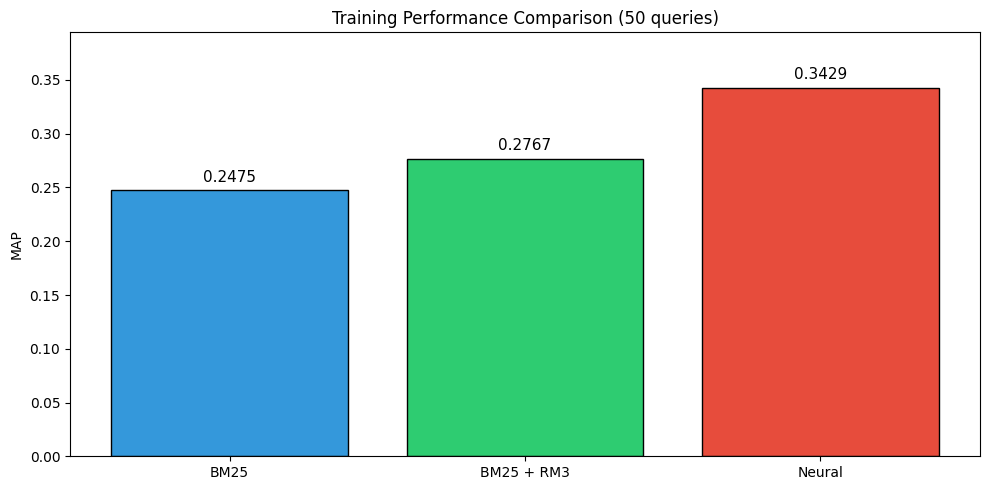


✓ All models tuned and evaluated on training queries

→ Ready to generate submission files for test queries


In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

methods = summary["Method"].tolist()
maps = summary["MAP"].tolist()
colors = ["#3498db", "#2ecc71", "#e74c3c"]

bars = ax.bar(methods, maps, color=colors, edgecolor="black")
ax.set_ylabel("MAP")
ax.set_title("Training Performance Comparison (50 queries)")
ax.set_ylim(0, max(maps) * 1.15)

for bar, m in zip(bars, maps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{m:.4f}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ All models tuned and evaluated on training queries")
print("\n→ Ready to generate submission files for test queries")

## 8. Generate Submission Files

---

**Final Step**: Using the best configurations from each model, we generate predictions for the 199 test queries (without relevance judgments)

Each model produces a TREC-formatted run file with 1000 ranked documents per query.

### 8.1. Run Inference on Test Queries

In [26]:
print("=" * 80)
print(f"GENERATING SUBMISSION FILES: {len(test_queries)} test queries (no qrels)")
print("=" * 80)
print()

# Run 1: Model 1 - BM25 Baseline
print("Run 1: Model 1 - BM25 Baseline")
print(f"  k1={best_k1}, b={best_b}")
run_1 = bm25_model.search(test_queries, k=1000)
print(f"  ✓ {len(run_1)} queries processed")

# Run 2: Model 2 - BM25 + RM3
print("\nRun 2: Model 2 - BM25 + RM3 Query Expansion")
print(f"  k1={best_k1}, b={best_b}, fb_terms={best_fb_terms}, fb_docs={best_fb_docs}")
run_2 = rm3_model.search(test_queries, k=1000)
print(f"  ✓ {len(run_2)} queries processed")

# Run 3: Model 3 - Neural
print("\nRun 3: Model 3 - Neural Reranking")
print(f"  Passage: size={int(best_phase_3['passage_size'])}, stride={int(best_phase_3['passage_stride'])}")
print(f"  PRF: fb_docs={int(best_phase_3['prf_fb_docs'])}, top_passages={int(best_phase_3['prf_top_passages'])}")
print(f"  Expansion: terms={int(best_phase_3['expansion_terms'])}")
print(f"  Reranking: rerank_k={int(best_phase_3['rerank_k'])}")
print(f"  Fusion: rrf_k={int(best_phase_3['rrf_k'])}, alpha={best_phase_3['alpha']:.2f}")
run_3 = multi_branch_model.search(test_queries, k=1000)
print(f"  ✓ {len(run_3)} queries processed")

print("\n✓ All test queries processed")

GENERATING SUBMISSION FILES: 199 test queries (no qrels)

Run 1: Model 1 - BM25 Baseline
  k1=0.6, b=0.4


BM25 Search: 100%|██████████| 199/199 [00:17<00:00, 11.23it/s]


  ✓ 199 queries processed

Run 2: Model 2 - BM25 + RM3 Query Expansion
  k1=0.6, b=0.4, fb_terms=100, fb_docs=5


RM3 Search: 100%|██████████| 199/199 [00:21<00:00,  9.30it/s]


  ✓ 199 queries processed

Run 3: Model 3 - Neural Reranking
  Passage: size=256, stride=64
  PRF: fb_docs=10, top_passages=5
  Expansion: terms=12
  Reranking: rerank_k=500
  Fusion: rrf_k=20, alpha=0.60


SPLADE:   0%|          | 0/199 [00:00<?, ?it/s]

Attempting to initialize pre-built index beir-v1.0.0-robust04.splade-pp-ed.
/home/galnoy/.cache/pyserini/indexes/lucene-inverted.beir-v1.0.0-robust04.splade-pp-ed.20231124.a66f86f.c1a6fd094bb9e34e69e10040d9b0ad2a already exists, skipping download.
Initializing beir-v1.0.0-robust04.splade-pp-ed...


PRF + MiniLM: 100%|██████████| 199/199 [2:03:14<00:00, 37.16s/it]  


  ✓ 199 queries processed

✓ All test queries processed


### 8.2. Export TREC Format

In [27]:
def write_trec_run(
    run: Dict[str, List[Tuple[str, float]]],
    filepath: str,
    run_name: str
):
    """
    Write run to TREC format.
    Format: topic_id Q0 doc_id rank score run_name
    """
    with open(filepath, "w") as f:
        for qid in sorted(run.keys(), key=lambda x: int(x)):
            results = run[qid]
            # Sort by score descending
            sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
            for rank, (docid, score) in enumerate(sorted_results[:1000], start=1):
                f.write(f"{qid} Q0 {docid} {rank} {score:.6f} {run_name}\n")
    
    print(f"✓ Written: {filepath}")


print("Writing submission files...\n")

write_trec_run(run_1, "run_1.res", "run_1")
write_trec_run(run_2, "run_2.res", "run_2")
write_trec_run(run_3, "run_3.res", "run_3")

print("\n✓ All submission files written")

Writing submission files...

✓ Written: run_1.res
✓ Written: run_2.res
✓ Written: run_3.res

✓ All submission files written


### 8.3. Validate Output

In [ ]:
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Tuple


def validate_run_file(
    filepath: str,
    expected_queries: int = 199,
    max_docs_per_query: int = 1000,
    expected_tag: str | None = None,
):
    """
    Validate a TREC run file in a MAP-safe way.

    Enforces:
      - Proper 6-column TREC format
      - All expected queries appear exactly once
      - 1 ≤ docs per query ≤ max_docs_per_query
      - Ranks are contiguous starting at 1
      - Scores are non-increasing by rank
      - No duplicate docids per query
      - Optional: consistent run tag
    """
    query_rows: Dict[str, List[Tuple[int, str, float, str]]] = defaultdict(list)

    # ----------------------------
    # Parse & basic format checks
    # ----------------------------
    with open(filepath, "r", encoding="utf-8") as f:
        for ln, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) != 6:
                raise AssertionError(
                    f"{filepath}: line {ln} expected 6 columns, got {len(parts)}"
                )

            qid, q0, docid, rank_s, score_s, tag = parts

            if q0 != "Q0":
                raise AssertionError(
                    f"{filepath}: line {ln} column 2 expected 'Q0', got '{q0}'"
                )

            try:
                rank = int(rank_s)
            except Exception:
                raise AssertionError(
                    f"{filepath}: line {ln} rank not int: '{rank_s}'"
                )

            try:
                score = float(score_s)
            except Exception:
                raise AssertionError(
                    f"{filepath}: line {ln} score not float: '{score_s}'"
                )

            query_rows[qid].append((rank, docid, score, tag))

    # ----------------------------
    # Query count check
    # ----------------------------
    if len(query_rows) != expected_queries:
        raise AssertionError(
            f"{filepath}: expected {expected_queries} queries, got {len(query_rows)}"
        )

    # ----------------------------
    # Per-query validation
    # ----------------------------
    for qid, rows in query_rows.items():
        n = len(rows)

        # Allow fewer than max_docs_per_query (TREC-correct)
        if not (1 <= n <= max_docs_per_query):
            raise AssertionError(
                f"{filepath}: qid {qid} has {n} docs, expected ≤ {max_docs_per_query}"
            )

        # Ranks: contiguous starting at 1
        ranks = [r for r, _, _, _ in rows]
        if len(set(ranks)) != len(ranks):
            raise AssertionError(f"{filepath}: qid {qid} has duplicate ranks")

        if set(ranks) != set(range(1, n + 1)):
            raise AssertionError(f"{filepath}: qid {qid} ranks not contiguous")

        # Docids: no duplicates
        docids = [d for _, d, _, _ in rows]
        if len(set(docids)) != len(docids):
            raise AssertionError(f"{filepath}: qid {qid} has duplicate docids")

        # Scores: non-increasing by rank
        scores = [s for _, _, s, _ in sorted(rows, key=lambda x: x[0])]
        if scores != sorted(scores, reverse=True):
            raise AssertionError(
                f"{filepath}: qid {qid} scores not non-increasing"
            )

        # Optional: run tag consistency
        if expected_tag is not None:
            tags = {t for _, _, _, t in rows}
            if tags != {expected_tag}:
                raise AssertionError(
                    f"{filepath}: qid {qid} unexpected tags {sorted(tags)}"
                )

    print(
        f"✓ {filepath}: {len(query_rows)} queries validated "
        f"(≤ {max_docs_per_query} docs per query)"
    )


print("Validating submission files...\n")

validate_run_file("run_1.res", expected_tag="run_1")
validate_run_file("run_2.res", expected_tag="run_2")
validate_run_file("run_3.res", expected_tag="run_3")

print("\n" + "=" * 60)
print("SUBMISSION FILES READY")
print("=" * 60)
print("Files: run_1.res, run_2.res, run_3.res")
print("Format: TREC 6-column")
print("=" * 60)


Validating submission files...

✓ run_1.res: 199 queries validated (≤ 1000 docs per query)
✓ run_2.res: 199 queries validated (≤ 1000 docs per query)
✓ run_3.res: 199 queries validated (≤ 1000 docs per query)

SUBMISSION FILES READY
Files: run_1.res, run_2.res, run_3.res
Format: TREC 6-column


## References

- **ROBUST04 / TREC Robust Track**
  - Voorhees, E. M. (2004). *Overview of the TREC 2004 Robust Retrieval Track.*  
    Proceedings of the Thirteenth Text REtrieval Conference (TREC 2004).

- **BM25 Ranking Function**
  - Robertson, S., Walker, S., Jones, S., Hancock-Beaulieu, M., & Gatford, M. (1994).  
    *Okapi at TREC-3.* Proceedings of the Third Text REtrieval Conference (TREC-3).

- **Relevance Model 3 (RM3) Query Expansion**
  - Lavrenko, V., & Croft, W. B. (2001).  
    *Relevance-Based Language Models.*  
    Proceedings of the 24th Annual International ACM SIGIR Conference on Research and Development in Information Retrieval.

- **Reciprocal Rank Fusion (RRF)**
  - Cormack, G. V., Clarke, C. L. A., & Buettcher, S. (2009).  
    *Reciprocal Rank Fusion Outperforms Condorcet and Individual Rank Learning Methods.*  
    Proceedings of the 32nd International ACM SIGIR Conference on Research and Development in Information Retrieval.

- **SPLADE (Sparse Learned Representations)**
  - Formal, T., Lassance, C., Piwowarski, B., & Clinchant, S. (2021).  
    *SPLADE: Sparse Lexical and Expansion Model for First Stage Ranking.*  
    Proceedings of the 44th International ACM SIGIR Conference on Research and Development in Information Retrieval.

- **Neural Cross-Encoder Reranking (MiniLM)**
  - Wang, W., Wei, F., Dong, L., Bao, H., Yang, N., & Zhou, M. (2020).  
    *MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers.*  
    Advances in Neural Information Processing Systems (NeurIPS).

- **Evaluation Framework**
  - Van Gysel, C., de Rijke, M., & Kanoulas, E. (2018).  
    *pytrec_eval: An Extremely Fast Python Interface to trec_eval.*  
    Proceedings of the 41st International ACM SIGIR Conference on Research and Development in Information Retrieval.
